Building an LDA Topic Model for Grouping Songs by Their Lyrics

In [3]:
import sys
!pip install spacy

  Using cached weasel-0.4.1-py3-none-any.whl (50 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl (29 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl (17 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl (22 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl (182 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl (27 kB)
  Using cached typer-0.13.1-py3-none-any.whl (44 kB)
  Using cached language_data-1.3.0-py3-none-any.whl (5.4 MB)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 2.0.2 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 2.0.2 which is incompatible.



  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
  Using cached confection-0.1.5-py3-none-any.whl (35 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl (9.8 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
  Using cached cloudpathlib-0.20.0-py3-none-any.whl (52 kB)
  Using cached smart_open-7.0.5-py3-none-any.whl (61 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: colorama
    Found existing installation: colorama 0.4.4
    Uninstalling colorama-0.4.4:
      Successfully uninstalled colorama-0.4.4
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: smart-open
    Found existing installation: s

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 600)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import spacy
import random
from gensim import models, corpora, similarities
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'spacy'

In [13]:
# Load data into list
songs_df = pd.read_csv("spotify_millsongdata.csv")
data = list(songs_df["text"])

# Print length and example
print("Number of songs:", len(data))
print("\nFirst song:", data[0])

Number of songs: 57650

First song: Look at her face, it's a wonderful face  
And it means something special to me  
Look at the way that she smiles when she sees me  
How lucky can one fellow be?  
  
She's just my kind of girl, she makes me feel fine  
Who could ever believe that she could be mine?  
She's just my kind of girl, without her I'm blue  
And if she ever leaves me what could I do, what could I do?  
  
And when we go for a walk in the park  
And she holds me and squeezes my hand  
We'll go on walking for hours and talking  
About all the things that we plan  
  
She's just my kind of girl, she makes me feel fine  
Who could ever believe that she could be mine?  
She's just my kind of girl, without her I'm blue  
And if she ever leaves me what could I do, what could I do?




In [14]:
# Clean text
clean_data = [i.replace('\n','').replace('\r','') for i in data]

In [15]:
# Load English language model
nlp = spacy.load("en_core_web_sm")

# Disable named-entity recognition and parsing to save time
unwanted_pipes = ["ner", "parser"]

# Custom tokenizer using spacy
def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if t.is_alpha and not t.is_space and not t.is_punct and not t.is_stop and t.pos_ in ["ADJ","NOUN","VERB"]]

In [ ]:
%%time

# Tokenize data
tokenized_data = list(map(custom_tokenizer, nlp.pipe(clean_data, n_process=8, batch_size=1000)))

# Print example
print(tokenized_data[0])

In [ ]:
# Build dictionary of (token, ID) mappings
dct = corpora.Dictionary(tokenized_data)

# Print vocab size
print('Size of vocabulary before filtering:', len(dct))

# Filter overly low and high frequency tokens
dct.filter_extremes(no_below=5, no_above=0.5)

# Print vocab size
print('\nSize of vocabulary after filtering:', len(dct))

# Example mappings
print("\nExample mappings:", [(i,dct.token2id[i]) for i in tokenized_data[0][:10]])

Size of vocabulary before filtering: 49150

Size of vocabulary after filtering: 13236

Example mappings: [('look', 12), ('face', 2), ('wonderful', 26), ('face', 2), ('mean', 15), ('special', 20), ('look', 12), ('way', 25), ('smile', 19), ('see', 18)]


In [18]:
# Bag-of-Words sparse matrix
bow = [dct.doc2bow(i) for i in tokenized_data]


In [37]:
%%time

# Train LDA model
lda_model = models.LdaModel(corpus=bow, num_topics=10, passes=1, alpha='auto', eta='auto', id2word=dct, random_state=0)




CPU times: total: 12.1 s
Wall time: 33 s


In [39]:
# Print generated topics
lda_model.print_topics()

[(0,
  '0.057*"love" + 0.029*"time" + 0.024*"heart" + 0.020*"way" + 0.017*"life" + 0.016*"find" + 0.016*"day" + 0.016*"tell" + 0.015*"feel" + 0.013*"try"'),
 (1,
  '0.098*"baby" + 0.087*"love" + 0.074*"want" + 0.067*"let" + 0.040*"need" + 0.032*"get" + 0.029*"wanna" + 0.028*"tonight" + 0.027*"go" + 0.013*"tell"'),
 (2,
  '0.053*"get" + 0.024*"man" + 0.012*"be" + 0.011*"money" + 0.010*"fuck" + 0.009*"big" + 0.009*"shit" + 0.009*"nigga" + 0.009*"rock" + 0.008*"go"'),
 (3,
  '0.039*"love" + 0.030*"dream" + 0.020*"fly" + 0.019*"come" + 0.018*"free" + 0.017*"sky" + 0.016*"soul" + 0.014*"sing" + 0.014*"star" + 0.013*"high"'),
 (4,
  '0.058*"go" + 0.021*"leave" + 0.020*"think" + 0.019*"want" + 0.017*"come" + 0.016*"run" + 0.015*"head" + 0.014*"fall" + 0.014*"time" + 0.013*"say"'),
 (5,
  '0.125*"come" + 0.061*"good" + 0.020*"sweet" + 0.019*"like" + 0.017*"play" + 0.015*"time" + 0.013*"kiss" + 0.013*"lady" + 0.012*"night" + 0.012*"look"'),
 (6,
  '0.019*"hear" + 0.015*"dance" + 0.015*"night" +

In [40]:
print(lda_model.alpha) # Document-topic prior
print(lda_model.eta) # Topic-word prior (beta)

[0.34313977 0.10442912 0.1724664  0.10820013 0.17720418 0.10625308
 0.18709558 0.11166203 0.11689272 0.14600532]
[1.7093872  2.5412664  4.5514536  ... 0.06670386 0.06638208 0.06640063]


In [41]:
# Get topics
topics = list(lda_model.get_document_topics(bow, minimum_probability=0))

# Print topic proportion in corpus
for i in range(10):
    print(f"Topic {i} proportion: {100*sum([pair[i][1] for pair in topics])/len(topics):.1f}%")

Topic 0 proportion: 26.8%
Topic 1 proportion: 7.7%
Topic 2 proportion: 10.8%
Topic 3 proportion: 7.1%
Topic 4 proportion: 10.4%
Topic 5 proportion: 5.0%
Topic 6 proportion: 12.6%
Topic 7 proportion: 5.6%
Topic 8 proportion: 6.4%
Topic 9 proportion: 7.4%


In [43]:
# Return top topics in a song
def get_top_topics(song_idx, min_prob):

    # Sort topics from highest to lowest frequency
    topics = sorted(lda_model.get_document_topics(bow[song_idx], minimum_probability=min_prob), key=lambda tup: tup[1])[::-1]

    # Get word distribution for each topic
    pairs = [lda_model.show_topic(pair[0]) for pair in topics]
    topic_words = [[pair[0] for pair in topic] for topic in pairs]

    return pd.DataFrame({'Major Topics': topics,'Topic Words': topic_words})

In [44]:
# Example
display(get_top_topics(100, 0.25))
print(data[100][:300])

,Major Topics,Topic Words
0,"(8, 0.9191925)","[light, burn, life, die, fight, live, people, world, shake, fire]"


The city is a jungle, you better take care  
Never walk alone after midnight  
If you don't believe it you better beware  
Of me  
  
I am behind you, I'll always find you, I am the tiger  
People who fear me never go near me, I am the tiger  
  
The city is a nightmare, a horrible dream  



In [45]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow))  # a measure of how good the model is. lower the better.

# Coherence score (closer to 0 the better)
coherence_model_Umass = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='u_mass')
coherence_score = coherence_model_Umass.get_coherence()
print(f'UMass Coherence Score: {coherence_score:.4f}')


Perplexity:  -7.11512995203075
UMass Coherence Score: -2.0361


In [46]:
coherence_model_Uci = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='c_uci')
coherence_score = coherence_model_Uci.get_coherence()
print(f'Ucis Coherence Score: {coherence_score:.4f}')

Ucis Coherence Score: 0.0939


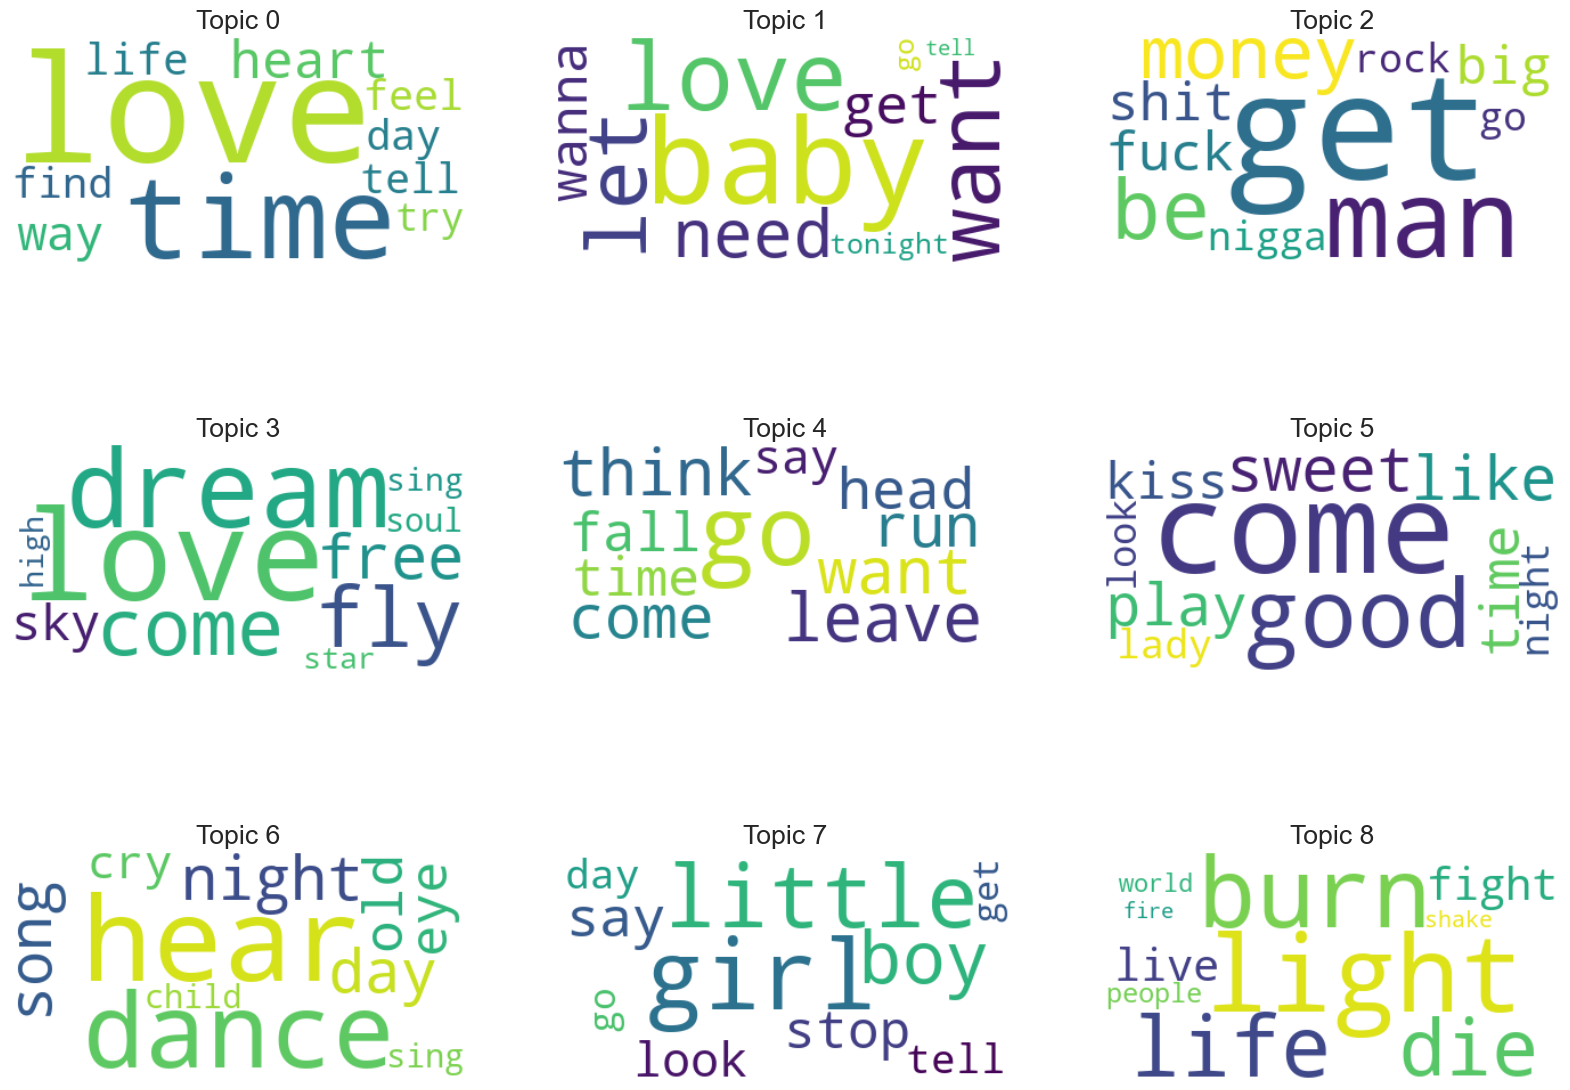

In [47]:
# Plot word clouds for each topic
word_cloud = WordCloud(background_color='white', max_words=10)
fig, axes = plt.subplots(3, 3, figsize=(20,15))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_model.show_topic(i))
    word_cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(word_cloud, interpolation='bilinear')
    plt.gca().set_title(f'Topic {i}')
    plt.gca().axis('off')
plt.show()

Similar Documents

In [ ]:
# Compute and rank consine similarities
lda_index = similarities.MatrixSimilarity(lda_model[bow], num_features=len(dct))

In [31]:
# Returns most similar songs to a given song
def get_similar_songs(song_bow, top_n=5, first_m_words=300):
    similar_songs = lda_index[lda_model[song_bow]]
    top_n_docs = sorted(enumerate(similar_songs), key=lambda item: -item[1])[1:top_n+1]
  
    # Returns (song id, similarity score, first_m_words of song)
    return list(map(lambda entry: (entry[0], entry[1], clean_data[entry[0]][:first_m_words]), top_n_docs))

In [32]:
# Example
print(data[6864][:300],'\n')
get_similar_songs(bow[6864])

[Verse:]  
She's just a girl and she's on fire  
Hotter than a fantasy, lonely like a highway  
She's living in a world and it's on fire  
Filled with catastrophe, but she knows she can fly away  
  
Ohhhh oh oh oh oh  
She got both feet on the ground  
And she's burning it down  
Ohhhh oh  



[(54969,
  0.9676974,
  "I'm in league with Satan  I was raised in hell  I walk the streets of Salem  Amongst the living dead  I need no one to tell me  What's wrong or right  I drink the blood of children  Stalk my prey at night    [Chorus]  Look out beware  When the full moon's high n' bright  In every way I'm there  In e"),
 (15409,
  0.9592578,
  "Don't you know I love you more than life itself,  Don't you know that you're my pride  And I would not have you walking through this world.  Without me by your side    Go to sleep my little man  Don't you weep my little man    I'd like to keep you with me all your life,  But I know I can't do that  "),
 (29347,
  0.9583821,
  "Look out!  Mama let me out on a Saturday night, she said now  Go out and get her go and hold her tight  I said now Mama, you don't understand  Ev'ry time I touch her hand  It's like I'm burning in the fires of hell  And if I hold her too long  You never can tell what'll happen to me  I wouldn't want"),
 (17284,
  0.

In [33]:
#Songs not in corpus
# Pass new song through pipeline
new_song = "Demons on my shoulder Monsters in my head Shadow in the water Will you be my friend The world revolves around me As I lay in my bed Dreaming of more, more"
new_tokens = list(map(custom_tokenizer, [nlp(new_song)]))[0]
new_bow = dct.doc2bow(new_tokens)

print(new_song,'\n')
get_similar_songs(new_bow)

Demons on my shoulder Monsters in my head Shadow in the water Will you be my friend The world revolves around me As I lay in my bed Dreaming of more, more 



[(40043,
  0.9927134,
  "Going back to Alabama.    Going back to Alabama  Now that I've learned the thing too  Life with me ain't been so easy  But I've got some living yet to do.    'Cos a man who walks by the side of the road  Can turn himself around  He can pick himself fast, just himself fast  And start all over again, "),
 (19642,
  0.99182177,
  "The drunken clown's still hanging round  But it plain the laughter's all died down  The tears you tried so hard to hide  Are flowin'  A blind man with his knife in hand  Has convinced himself that he understands  I wish him well, Miss Carousel  But I gotta be a-goin'    Won't you come and get me whe"),
 (50126,
  0.99124324,
  "Hope you didn't burn too many bridges  On your way back to haunt my heart  Cause it's safe behind these stones and ridges  You know how us healin' victims are  I take comfort where I find it  In the neon and the crowds  I guess someone like me designed it  This place where old flames aren't allowed "),
 (49557,
  